In [1]:
from astropy.table import Table

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
from glob import glob

from scipy.ndimage import gaussian_filter1d

from desispec.io import read_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras

In [2]:
mpl.rc('font', size=14)

In [3]:
tfevtab = Table.read('cache/tf_targets_everest.fits')
tfcomatab = Table.read('cache/tf_targets_coma_sga.fits')
tfcomatab

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
TFT,6443,39628449261815639,194.015001968576,28.4347616870916,0,120,194.014992822247,28.4347575427582,0.0228077753473186,9.49692763345357e-06,GALAXY,12502.420789832,0,SGA-2020 6443,2MASXJ12560357+2826049,3798694,194.0150415,28.434759200000002,E,0.15,0.42953643,0.52966344,0.022773754,23.495481,16.702,False,LEDA-20181114,1749,2MASXJ12560357+2826049,1,True,194.0150415,28.434759200000002,0.42953643,1940p285,194.01499282224725,28.434757542758188,0.5758262,SB26,178.74611,0.5289391,194.0149013047641,28.43482627995438,11.529113,3.4933767,3.4790735,3.5417385,6.7043676,7.8427553,9.000888,10.051459,10.989381,12.259024,13.601412,15.212001,17.274786,16.533848,15.79303,15.308514,16.449266,15.712977,15.225233,16.390287,15.657084,15.167129,16.35449,15.6234045,15.132558,16.331707,15.60235,15.110845,16.310932,15.585337,15.0910425,16.299269,15.57684,15.080532,16.28742,15.564971,15.069217,16.278936,15.554956,15.059705,0.095610216,0.095818155,0.104093984,0.11963359,0.09470798,0.12928808,0.14805332,0.1717031,0.20933938,0.03951728,0.0422584,0.039743226,0.037378095,0.040008463,0.03761356,0.035762083,0.038332522,0.03601092,0.03476994,0.03730794,0.03504701,0.034159563,0.036694754,0.03445771,0.033523172,0.03611823,0.03383837,0.0332151,0.035883322,0.033557374,0.032830115,0.035464935,0.033186853,0.032

In [4]:
def get_spectra_for_sga(targtab, sga_id, redux='everest/tiles/cumulative'):
    """Access spectra corresponding to all observations of a given SGA galaxy.
    
    Parameters
    ----------
    targtab : astropy.table.Table
        List of SGA + TFT observations.
    sga_id : int
        SGA ID of the central galaxy we're querying.
    redux : str
        The spectroscopic reduction we want to access.
    """
    prefix = '/'.join([os.environ['DESI_SPECTRO_REDUX'], redux])
    
    targets = targtab[targtab['SGA_ID'] == sga_id]
    targets.sort('TILEID')
    
    targetids = targets['TARGETID']
    tileids = targets['TILEID']
    
    coadd_spectra = None
    
    # Grab coadd files for this tile.
    for targetid, tileid in zip(targetids, tileids):
        tilefolder = sorted(glob('{}/{:d}/2*'.format(prefix, tileid)))[-1]
        tilefiles = sorted(glob('{}/coadd*.fits'.format(tilefolder)))
        
        # Grab the spectra corresponding to the TARGETID we queried.
        for tilefile in tilefiles:
            fmap = Table.read(tilefile, 'FIBERMAP')
            in1d = np.in1d(fmap['TARGETID'], targetid)
            
            # If we have something, read in the spectra and coadd across b,r,z cameras.
            if np.any(in1d):
                spectra = read_spectra(tilefile)[in1d]
                coadds = coadd_cameras(spectra)
                coadds.scores = None
                
                # Store the coadded spectra in a data structure.
                if coadd_spectra is None:
                    coadd_spectra = coadds
                else:
                    coadd_spectra = specstack([coadd_spectra, coadds])
                    
    return coadd_spectra

In [5]:
sga_ids = np.unique(tfcomatab['SGA_ID'])
coadds = get_spectra_for_sga(tfcomatab, sga_ids[2])

OSError: [Errno 5] Input/output error

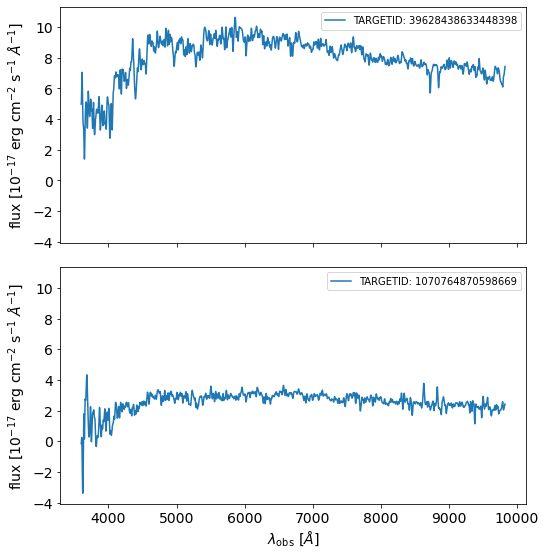

In [89]:
n = coadds.num_spectra()

fig, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

for i in range(n):
    wave = coadds.wave['brz']
    flux = coadds.flux['brz'][i]
    smoothed = gaussian_filter1d(flux, 7)
    
    ax = axes[i]
    ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
    ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
    if i+1 == n:
        ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')
            
    ax.legend(loc='upper right', fontsize=10)